In [1]:
import random
# import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import argparse

import pdb

from model import *
from metrics import *
from dataset import *
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import backend as K
from functools import wraps

from scipy.optimize import fmin_l_bfgs_b

from keras.losses import categorical_crossentropy
import time

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [4]:
# Config
tf.set_random_seed(777)


os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
# os.environ["CUDA_VISIBLE_DEVICES"]=device
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

# Parameters 
#0x0x-test-x_reduced_chd.log
test_name = "0x0x-test-x_reduced"
device = "0"
model_type = "U"
data = "chd"
option = "train"
image_size = 64
batch_size = 5#16
epochs = 50
learning_rate = 0.0001
num_classes = 4
base = 32
scale = 2
which_target = 1

In [5]:
# Setting base directory 
base_dir = './input/chd'
x_train_dir = os.path.join(base_dir, 'x_train', 'class')
x_valid_dir = os.path.join(base_dir, 'x_valid', 'class')
x_test_dir = os.path.join(base_dir, 'x_test', 'class')
y_train_dir = os.path.join(base_dir, 'y_train', 'class')
y_valid_dir = os.path.join(base_dir, 'y_valid', 'class')
y_test_dir = os.path.join(base_dir, 'y_test', 'class')

x_folders = os.listdir(x_train_dir)
x_folders = sorted(x_folders)
y_folders = os.listdir(y_train_dir)
y_folders = sorted(y_folders)

### 1. Preprocessing

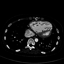

In [6]:
image_x = Image.open(os.path.join(x_train_dir, x_folders[100]))
image_x = image_x.resize((image_size, image_size))
image_x

In [7]:
x_= np.asarray(image_x)
x_sample = np.copy(x_)
x_sample = x_sample*(1/255.0)
x_sample.shape
# np.unique(x_sample)

(64, 64)

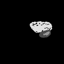

In [8]:
image_y = Image.open(os.path.join(y_train_dir, y_folders[100]))
image_y = image_y.resize((image_size, image_size))
image_y

In [79]:
y_sample = np.asarray(image_y)
y_sample = np.copy(y_sample)
print(y_sample.shape)
print(np.unique(y_sample))

(64, 64)
[  0   1   2   5   6   8   9  10  12  15  16  22  23  25  26  28  30  31
  32  34  35  36  38  40  42  44  45  47  52  55  56  57  59  60  62  65
  67  68  69  70  71  72  74  75  76  77  78  80  81  84  88  89  90  91
  92  93  94  95  97  98 101 105 106 107 109 110 111 118 119 120 123 125
 127 128 129 130 136 138 139 141 142 143 145 146 147 149 150 151 152 153
 154 155 157 159 164 166 167 175 176 177 179 180 181 182 185 186 188 189
 190 191 192 193 195 197 199 200 201 202 203 204 206 208 209 210 211 212
 214 215 216 217 218 219 220 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 239 241]


In [80]:
# need to preprocess Y (to have labels)

def creating_y_label(label):
# for (img,label) in data_gen:
    label[label < 50] = 0
    label[(label >= 50) & (label < 112.5)] = 75
    label[(label >= 112.5) & (label < 187.5)] = 150
    label[label >= 187.5] = 225
    label[label==75] = 1
    label[label==150] = 2
    label[label==225] = 3
#     label_adv = label
        # label_adv[label_adv==which_target] = 0 # YJS added
    label = to_categorical(label, num_classes=num_classes)
    return label

y_label = creating_y_label(y_sample)
y_label.shape

(64, 64, 4)

In [81]:
y_target = np.zeros((64,64,4))
y_target[:,:,0] = 1 # only background

### Visualizing y_true

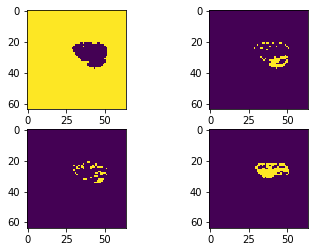

In [82]:
plt.title('Y_TRUE')
plt.subplot(2,2,1)
plt.imshow(y_label[:,:,0])
plt.subplot(2,2,2)
plt.imshow(y_label[:,:,1])
plt.subplot(2,2,3)
plt.imshow(y_label[:,:,2])
plt.subplot(2,2,4)
plt.imshow(y_label[:,:,3])

### Making a generalized function that switches a certain label into background

In [85]:
def making_adv_y(y_true, target_label):
    # y_true should be img_size * img_size * num_classes
    # target_label should be 1, 2, or 3 
    ind = y_true[:,:,target_label] == 1
    y_true[ind, 0] = 1 # For background class, add target label
    y_true[:,:,target_label] = 0
    return y_true

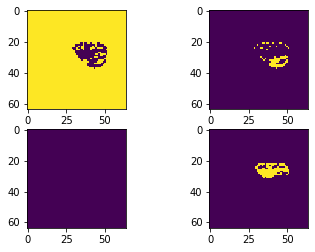

In [86]:
adv_y = making_adv_y(y_label, 2)
plt.title('Y_adv')
plt.subplot(2,2,1)
plt.imshow(adv_y[:,:,0])
plt.subplot(2,2,2)
plt.imshow(adv_y[:,:,1])
plt.subplot(2,2,3)
plt.imshow(adv_y[:,:,2])
plt.subplot(2,2,4)
plt.imshow(adv_y[:,:,3])

### Visualizing  y_pred

12713

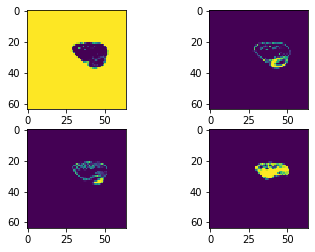

In [84]:
x_input = x_sample.reshape(1,image_size, image_size, 1)
y_input = y_label.reshape(1,image_size, image_size, 4)
# model.evaluate(x=x_input, y=y_input)
predicted_label = model.predict(x_input)
plt.title('Y-PRED')
plt.subplot(2,2,1)
plt.imshow(predicted_label[0,:,:,0])
plt.subplot(2,2,2)
plt.imshow(predicted_label[0,:,:,1])
plt.subplot(2,2,3)
plt.imshow(predicted_label[0,:,:,2])
plt.subplot(2,2,4)
plt.imshow(predicted_label[0,:,:,3])


# # plt.imshow(predicted_label[0,:,:,0])
a = np.unique(predicted_label)
len(a)

In [90]:
x_sample.shape
adv_y.shape

(64, 64, 4)

In [91]:
xx=x_sample.reshape(1,64,64,1)
yy=adv_y.reshape(1,64,64,4)
model.evaluate(x=xx, y=yy)

1/1 [==============================] - 0s 18ms/step


[0.2205335795879364,
 0.7903929948806763,
 0.800000011920929,
 2.4999999292951713e-10,
 0.8975265026092529]

In [ ]:
# def func2(params, *args): #우리가 구하려는건 model의 weights가 아니라 x_adv
#     params = np.clip(params, 0, 1)
#     params = params.flatten()
    
#     x = args[0]
#     y = args[1]
#     model = args[2]
#     epsilon = args[3]
    
    
#     x = x.flatten()
# #     x_adv = x + params*epsilon
#     x_adv = x + params
#     x_adv = x_adv.reshape((1,image_size,image_size,1))    
    
#     with tf.GradientTape() as tape:
#         tape.watch(x_adv)
        
# #     ori_img = x.reshape(1,image_size,image_size,1)
    

#     y = y.reshape((1,image_size,image_size,num_classes))

#     score_ = model.evaluate(x=x_adv, y=y, verbose=0)
#     score = score_[0]
    
# #     l2dist = np.sum(np.square(x_adv - x))
    
# #     loss = score + l2dist
#     #grad, = tf.gradients(score_, x_adv)
# #     return loss#, grad.flatten().astype(float)
#     return score

In [153]:
ans = model.predict( x_sample.reshape(1,image_size, image_size, 1))
ans.shape
np.unique(ans)

array([1.8281299e-24, 1.5927613e-23, 1.6326548e-23, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

In [267]:
import os
os.environ

environ{'LD_LIBRARY_PATH': '/usr/local/cuda-10.0/lib64',
        'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*.tgz=01;31:*.arc=01;31:*.arj=01;31:*.taz=01;31:*.lha=01;31:*.lz4=01;31:*.lzh=01;31:*.lzma=01;31:*.tlz=01;31:*.txz=01;31:*.tzo=01;31:*.t7z=01;31:*.zip=01;31:*.z=01;31:*.Z=01;31:*.dz=01;31:*.gz=01;31:*.lrz=01;31:*.lz=01;31:*.lzo=01;31:*.xz=01;31:*.zst=01;31:*.tzst=01;31:*.bz2=01;31:*.bz=01;31:*.tbz=01;31:*.tbz2=01;31:*.tz=01;31:*.deb=01;31:*.rpm=01;31:*.jar=01;31:*.war=01;31:*.ear=01;31:*.sar=01;31:*.rar=01;31:*.alz=01;31:*.ace=01;31:*.zoo=01;31:*.cpio=01;31:*.7z=01;31:*.rz=01;31:*.cab=01;31:*.wim=01;31:*.swm=01;31:*.dwm=01;31:*.esd=01;31:*.jpg=01;35:*.jpeg=01;35:*.mjpg=01;35:*.mjpeg=01;35:*.gif=01;35:*.bmp=01;35:*.pbm=01;35:*.pgm=01;35:*.ppm=01;35:*.tga=01;35:*.xbm=01;35:*.xpm=01;35:*.tif=01;35:*.tiff=01;35:*.png=01;35:*.svg=01;35:*.svgz=

In [262]:
def func2(params, *args): #우리가 구하려는건 model의 weights가 아니라 x_adv
    params = np.clip(params, 0, 1)
    params = params.flatten()
    sess=tf.Session()    
    x = args[0]
    y = args[1]
    model = args[2]
    epsilon = args[3]
    
    
    x = x.flatten()
#     x_adv = x + params*epsilon
    x_adv = x + params
    
    
#     ori_img = x.reshape(1,image_size,image_size,1)

    x_adv2 = x_adv.reshape((1,image_size,image_size,1)).astype('float32')
    y = y.reshape((1,image_size,image_size,num_classes))
    x_adv2 = tf.convert_to_tensor(x_adv2)
    
    score = model(x_adv2)
    loss = keras.losses.categorical_crossentropy(y, score)
    grad = tf.gradients(loss, x_adv2)
    sess = tf.InteractiveSession()
    sess.run(tf.initialize_all_variables())
#     print(sess.run(grad))
#     print(grad.shape)
    grad = sess.run(grad)
    grad = np.array(grad)
    grad=np.squeeze(grad)
    print(grad.shape)
    return score, grad.flatten().astype('double')

In [263]:
start = time.time()
adv_x, f, d = fmin_l_bfgs_b(func2, x0=initial_flatten, fprime = args=(x_sample,adv_y, model, epsilon), bounds = clip_bound, iprint=0)
print("time :", time.time() - start)

(64, 64)


SystemError: _lbfgsb.setulb() 6th argument (f) can't be converted to double

In [118]:
# lbfgs optimization parameters
# mybounds = [(None,2), (None,None)]
max_iter = 1000
epsilon = 0.5
initial_image = np.zeros(np.shape(x_sample))
initial_flatten = initial_image.flatten().astype(float)
# initial_flatten.shape

# oimgs = np.clip(x_sample, 0, 1)
# oimgs_flatten = oimgs.flatten()
# oimgs_flatten.shape
model = load_model(filepath="./save/"+str(test_name)+"_"+data+".hdf5",
               custom_objects={'dice_categorical_crossentropy': dice_categorical_crossentropy,
                               'dice_coef': dice_coef,
                               'dice_coef_1': dice_coef_1,
                               'dice_coef_2': dice_coef_2,
                               'dice_coef_3': dice_coef_3,
                               'Scale': scale})

In [113]:
clip_min=0
clip_max=1



# set the box constraints for the optimization function
clip_min = clip_min * np.ones(x_sample.shape[:])
clip_max = clip_max * np.ones(x_sample.shape[:])
clip_bound = list(zip(clip_min.flatten(), clip_max.flatten()))

TypeError: Fetch argument None has invalid type <class 'NoneType'>

In [135]:
d['warnflag']
d['nit']

0

In [129]:
adv_x_reshape = adv_x.reshape(image_size, image_size)

In [130]:
np.unique(adv_x)

array([0.])

In [122]:
np.unique(y_label)

array([0., 1.], dtype=float32)

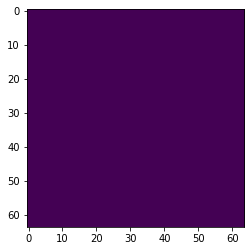

In [123]:
plt.imshow(adv_x_reshape)

In [ ]:
np.unique(adv_x_reshape)

In [ ]:
# np.unique(x_sample)

In [ ]:
plt.imshow(x_sample)

In [ ]:
aa = x_sample==adv_x_reshape
np.unique(aa)

In [ ]:
final = adv_x_reshape + x_sample
plt.imshow(final)

In [ ]:
np.save('sample_advimg.npy', adv_x)

In [ ]:
image_x_ = x_sample.reshape(1,image_size,image_size,1)
aaa = model.predict(image_x_)
plt.title('Original segmentation')
plt.subplot(2,2,1)
plt.imshow(aaa[0,:,:,0])
plt.subplot(2,2,2)
plt.imshow(aaa[0,:,:,1])
plt.subplot(2,2,3)
plt.imshow(aaa[0,:,:,2])
plt.subplot(2,2,4)
plt.imshow(aaa[0,:,:,3])


In [ ]:
adv_final_x = final.reshape(1, image_size, image_size, 1)
bbb = model.predict(adv_final_x)
plt.title('Adversarial segmentation')
plt.subplot(2,2,1)
plt.imshow(bbb[0,:,:,0])
plt.subplot(2,2,2)
plt.imshow(bbb[0,:,:,1])
plt.subplot(2,2,3)
plt.imshow(bbb[0,:,:,2])
plt.subplot(2,2,4)
plt.imshow(bbb[0,:,:,3])
